# Introduction to Machine Learning in Python

**Do Androids Dream of Electric Sheep?**

---

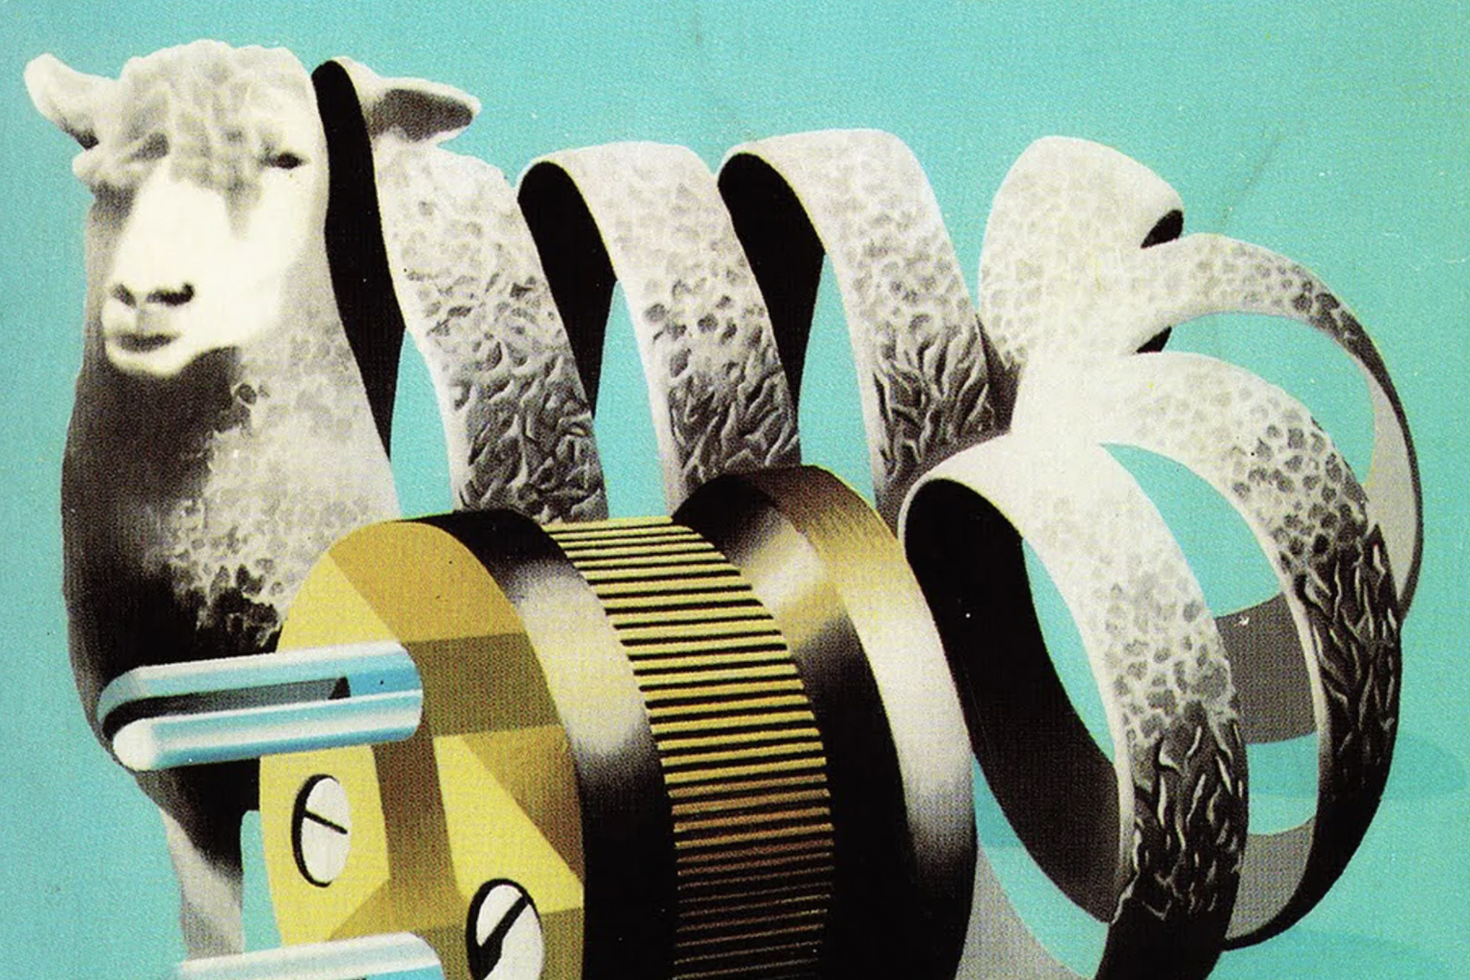

# Session Overview

Now that you've had some experience using R for data wrangling and presentation, we're going to move over to Python to look at **model training** and **model evaluation** in this session. These are the key components of the machine learning pipeline that inform our **model selection,** i.e., choosing an algorithm to solve our desired prediction task with data.

We're going to get some practice for two common types of machine learning tasks:

1. Regression (supervised learning)
2. Classification (supervised learning)

It's important to note that model training and evaluation are not followed sequentially in practice, but instead iterated over to obtain the final model. We'll try to get a sense of what this looks like in the session.

### Why Python?
The content in today's session could be accomplished in either R or Python. Python is more widely used for machine learning tasks, especially when considering neural networks (which will be discussed during IAP). We are introducing today's material in Python to give a flavor of a different programming language, including its syntax and functionality. The material for today's session is adapted from **COS 2021's Modeling and ML** session using R. Feel free to refer to these [slides](https://github.com/adelarue/cos_2020/tree/master/4_modeling_and_ml) for similar session content in R syntax.

# Part 0: Preparing Data

To prepare our environment for today's session, we will begin by loading pandas, a core Python library for data analysis. Most of our machine learning work will be done using scikit-learn; we will load some additional libraries as we go through the session.

In [ ]:
import pandas as pd
import numpy as np
import random

In [ ]:
#Instead of uploading the data manually, I host it on my dropbox and obtained a shareable link.
#Then we can use the command wget to download the csv.
!wget -O listings_with_amenities.csv https://www.dropbox.com/s/esvy5et863v7ugm/listings_with_amenities.csv?dl=0

--2021-10-25 23:00:03--  https://www.dropbox.com/s/esvy5et863v7ugm/listings_with_amenities.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/esvy5et863v7ugm/listings_with_amenities.csv [following]
--2021-10-25 23:00:03--  https://www.dropbox.com/s/raw/esvy5et863v7ugm/listings_with_amenities.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucadd2facaed983d0d80abb8ef3d.dl.dropboxusercontent.com/cd/0/inline/BYv_810XYVWUim8OAW2CoeLLVTyyaTSLM0_kImR8Tti35NrYEoE3jnvYQNXDEdh6C-__QM7PRezTQY75M6634MVFvyAWjOVdlUJxxOq65exQ31xEa9JGqGkxbF3T-x7iV1FT-HN5Qd4VjTNbsKU1iROb/file# [following]
--2021-10-25 23:00:04--  https://ucadd2facaed983d0d80abb8ef3d.dl.dropboxusercontent.com/cd/0/inline/BYv_810XYVWUim8OAW2CoeLLVTyyaTSLM0_kI

In [ ]:
## Load the data
listings_raw = pd.read_csv('listings_with_amenities.csv')

In [ ]:
## Explore the first 10 rows
listings_raw.head(10)

id  ... amenity_Free_Parking_on_Street
0  12147973  ...                              0
1   3075044  ...                              0
2      6976  ...                              0
3   1436513  ...                              0
4   7651065  ...                              0
5  12386020  ...                              0
6   5706985  ...                              0
7   2843445  ...                              0
8    753446  ...                              0
9    849408  ...                              0

[10 rows x 140 columns]

In [ ]:
## Display the columns names
listings_raw.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'amenity_Other_pets', 'amenity_Washer___Dryer',
       'amenity_Smoking_Allowed', 'amenity_Suitable_for_Events',
       'amenity_Wheelchair_Accessible', 'amenity_Elevator_in_Building',
       'amenity_Pool', 'amenity_Doorman', 'amenity_Paid_Parking_Off_Premises',
       'amenity_Free_Parking_on_Street'],
      dtype='object', length=140)

Before moving forward, let's do some basic data cleaning.

In [ ]:
def clean_price(p):
    p = p.replace('$','').replace(',','') # replace all '$' and ',', similar to in R
    return float(p)

# We will "apply" this function to eacch element of our price column, and replace the price column with these values
listings_raw.loc[:,'price'] = listings_raw.loc[:,'price'].apply(lambda x: clean_price(x))
listings_raw.loc[:,'price']

0       250.0
1        65.0
2        65.0
3        75.0
4        79.0
        ...  
3580     69.0
3581    150.0
3582    198.0
3583     65.0
3584     65.0
Name: price, Length: 3585, dtype: float64

In [ ]:
# We'll also clean up some outliers
listings_clean = listings_raw.query('accommodates <= 10 & price <= 1000')
listings_clean = listings_clean.query('maximum_nights <= 2000')

# Filter by property type
listings_clean = listings_clean[listings_clean['property_type'].isin(["Apartment", "House", "Bed & Breakfast", "Condominium", "Loft", "Townhouse"])]
listings_clean = listings_clean[~listings_clean['neighbourhood_cleansed'].isin(["Leather District", "Longwood Medical Area"])]

# Find columns with sufficient fill (at most 25% missing values)
cols_keep = listings_clean.columns[listings_clean.isnull().mean() <= 0.25]
listings_clean = listings_clean.loc[:,cols_keep]

# Let's one-hot encode our property types
listings_clean = pd.get_dummies(listings_clean, columns = ['property_type'], drop_first = True)

# We're also going to filter to numeric columns for now- 
# You can use one-hot encoding to handle categorical variables, but today we'll stick to this.
listings_clean = listings_clean.select_dtypes(include=np.number)


In [ ]:
# Where are there missing values?
missing_vals = listings_clean.isna().sum()
missing_vals.index[missing_vals>0]

Index(['bathrooms', 'bedrooms', 'beds', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'reviews_per_month'],
      dtype='object')

Let's impute the missing data - we will simply impute the mean. There are other options available in `sklearn.impute`.
Notice that the missingness is in numeric columns only, which makes it easier to deal with. If there are categoric columns with missing data, different approaches need to be taken (e.g. mode imputation).

In [ ]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(listings_clean)

# Get the imputed values and convert back into a dataframe (it will return a matrix)
listings = pd.DataFrame(imp_mean.transform(listings_clean), 
                        columns = listings_clean.columns)

Let's see what our feature space looks like now.  

# Part 1: Regression

We're going to start by solving a regression problem.

**Inputs**

Regression is a supervised learning problem, which means that we have access to a dataset $\mathcal{D} = \{ (x_i, y_i) \}_{i = 1}^{n}$ where each $x_i \in \mathbb{R}^d$ and each $y_i \in \mathbb{R}$.

Note that for regression, the output, $y$, is *continuous*. If the output is discrete, such as whether or not an apartment listing will be rented (yes/no) or what town the unit is listed in (multiple classes: Boston vs. Cambridge vs. Somerville), we would use a *classification* algorithm. We will consider these in part 2 of the session.
 
**Aim**

The aim of a regression task is to find a function $h: \mathbb{R}^d \to \mathbb{R}$ which allows us to compute an accurate prediction of the output, $y$, for any given input, $x$. These new $x$ and $y$ are *unseen*: that is, we assume they are identically distributed relative to the points in $\mathcal{D}$, but independent.

Exactly what we mean by *accuracy* will be discussed when we talk about model evaluation.

The way we approach the problem of finding $h$ is by selecting a parameterised class of models, and solving an optimization problem to find the best model within this class according to a *loss function*. We usually repeat this process for several model classes.

### Defining our Regression Task

We're going to use the Boston Airbnb dataset, where each entry is a property listing, and aim to use the input variables available to us in order to predict the price of a listing.

Note here that we haven't specified exactly which variables in the dataset will be used to define each $x_i$. This choice of **feature space** is part of the modeling process, and we will experiment with it.

### Ordinary Least Squares

The first class of models we're going to try is linear models. This means we hypothesise that the output, $y$, can be described using a linear combination of the inputs, $x$: $h(x) = \beta^{\intercal} x$.

**Question**: What are the tunable parameters (hyperparameters) for the class of OLS models?

**Answer**: There aren't really any. If we restrict ourselves to OLS, then the only choice we need to make is which variables to include as inputs.

#### Fitting an OLS Model 

Now, we need to choose exactly which inputs will be used for fitting the model. Which inputs might be predictive of price? Recall the column names:

For a very simple model, let's just choose `accommodates` as the only input. To fit this model we will use linear regression in scikit-learn:

In [ ]:
from sklearn.linear_model import LinearRegression

X = listings[['accommodates']]
y = listings['price']

# Select the model type
model = LinearRegression()

# Fit the model to our data
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

We've trained our first model! Let's look at the model output. You can see the elements of the `model` object by typing `model.` and pressing "tab."

In [ ]:
print(model.coef_)
print(model.intercept_)

[38.18050078]
53.6734636459187


Let's look at the 'coefficients' section. In the 'estimate' column, we see that the point estimates for the model coefficients say that the price estimate is \\$53.67 + \\$38.18*(# of people accommodated). 

To visualise the model, let's plot the fitted line. We'll use `matplotlib` for our plotting, which offers similar functionality to `ggplot2` in R.

Text(0.5, 1.0, 'OLS Model Fit')

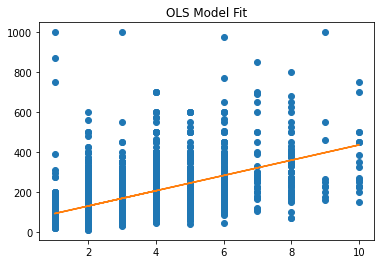

In [ ]:
import matplotlib.pyplot as plt

# Start with a scatterplot of the data
plt.plot(X, y, 'o')

# Add in the regression line
y_pred = model.predict(X)
plt.plot(X, y_pred)
plt.title('OLS Model Fit')

Let's look the model residuals for each accommodation size to see how appropriate the linear model is for this problem. 

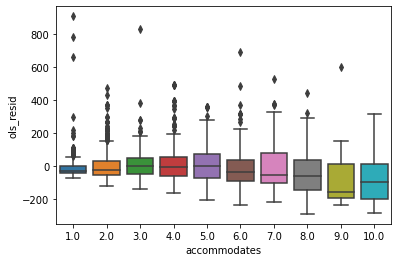

In [ ]:
import seaborn as sns # another helpful plotting library

# We'll add the OLS predictions and residuals to our dataframe, and then plot them
resid = (y - y_pred)
listings['ols_pred'] = y_pred
listings['ols_resid'] = resid
sns.boxplot(x='accommodates', y='ols_resid', data=listings)


**Question**: What do these box plots tell us about the model?

**Answer**: Although the residuals seem relatively centered around zero, there does appear to be some right skew. Also, the higher accommodation residuals look less centered. Perhaps the model doesn't apply so well here.


### Evaluation

Now we're going to look at two measures of accuracy for regression models -- in other words, how well a model explains a dataset.

The first is the mean squared error (MSE), which is simply computed as the mean of the squared residuals. Recall that the residuals are stored in the `resid` variable:

In [ ]:
mse = np.mean(resid**2)
mse

8529.512169087424

We can also calculate the RMSE, (root) MSE, from a model applied to a dataset:

In [ ]:
rmse = np.sqrt(np.mean(resid**2))
rmse

92.35535809625462

Scikit-learn has built-in evaluation functions that can do this for you. We'll also print the results out using Python's number formatting to show the MSE/RMSE rounded to two decimals.

In [ ]:
from sklearn import metrics
mse = metrics.mean_squared_error(y, y_pred)
rmse = metrics.mean_squared_error(y, y_pred, squared = False)
print("MSE = %.2f" % mse)
print("RMSE = %.2f" % rmse)

MSE = 8529.51
RMSE = 92.36


Clearly this measure is highly affected by the scale of the data. We can also use the 'R squared' coefficient, which is more interepretable since it is on a standardized scale.

In [ ]:
def r_squared(y_true, y_pred, y_mean):
    ss_res = ((y_true - y_pred)**2).sum()
    ss_tot = ((y_true - y_mean)**2).sum()
    return (1 - (ss_res/ss_tot))

r2 = r_squared(y, y_pred, np.mean(y))
print("R^2 = %.2f" % r2)

R^2 = 0.32



The R squared value is what we will use to evaluate the performance of our models in this session. But, it's important to note that this is definitely not the only choice we could have made! Check out scikit-learn's full library of [evaluation metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) to see what else is out there.

**Question**: What is the relationship between the loss function and the measure of accuracy used to evaluate a model? How do we know which is the best choice for each?

**Answer**: The loss function is used to fit a model, and the measure of accuracy is used to evaluate how well it explains the data. The measure of accuracy usually comes from the task we aim to solve, and the loss function is often something that we will play around with until we find a good model. 

#### Training, Validation and Testing Splits

Recall that our ultimate goal in this supervised learning task is to be able to predict price ($y$) from an *unseen* set of inputs ($x$, although we are still playing around with the input variables which define it).

When building the OLS model, we used the entire dataset. Simply taking the R squared value on this dataset as a measure of performance is clearly not fair -- since we want the model to generalise to unseen data.

To address this problem, we often split the dataset into three different chunks:

1. **Training data**: the data we build our models on.
2. **Validation data**: the data we tune hyperparameters on.
3. **Testing data**: the data we use to obtain a final estimate of performance.

The validation set is like an 'intermediate' estimate of performance. If we didn't use the validation set for this purpose, the only way of selecting the best model from a model class would be to look at its performance on the training set or the testing set.

`train_test_split` in scikit-learn provides an easy way of creating these data partitions. Let's start by just creating training/testing sets. We'll get to parameter tuning in a minute.

In [ ]:
from sklearn.model_selection import train_test_split

features =  listings.columns.drop(['id', 'scrape_id', 'host_id', 'latitude', 'longitude', 
                                   'availability_30','availability_60', 'availability_90', 'availability_365',
                                   'host_total_listings_count','calculated_host_listings_count',
                                   'price', 'ols_pred', 'ols_resid'])

X_train, X_test, y_train, y_test = train_test_split(listings[features], listings['price'], 
                                                    train_size = 0.75, random_state = 1)

print("Training Size = %d" % X_train.shape[0]) # To print integers, we can pass '%d' into our print statement 
print("Testing Size = %d" % X_test.shape[0])

Training Size = 2624
Testing Size = 875


Let's now observe our training data and do some basic pre-processing before training the models.

In [ ]:
########### TODO ############
#Describe the data (similar to summary() in R)
X_train.describe()#.transpose()

host_listings_count  ...  property_type_Townhouse
count          2624.000000  ...              2624.000000
mean             59.635290  ...                 0.014863
std             172.574398  ...                 0.121027
min               0.000000  ...                 0.000000
25%               1.000000  ...                 0.000000
50%               2.000000  ...                 0.000000
75%               7.000000  ...                 0.000000
max             749.000000  ...                 1.000000

[8 rows x 67 columns]

In [ ]:
#@title What do you remark? What should we do?
#@ We should normalize or standardize our data, so that features are on the same scale.

### The "manual" way ###

# Normalization
X_train_normalized = (X_train - X_train.min())/(X_train.max()-X_train.min())
X_test_normalized = (X_test - X_train.min())/(X_train.max()-X_train.min())

# Standardization
X_train_standardized = (X_train - X_train.mean())/X_train.std()
X_test_normalized = (X_test - X_train.mean())/X_train.std()

### The "package" way ###

# Normalization
from sklearn.preprocessing import MinMaxScaler

norm_scaler = MinMaxScaler()
norm_scaler.fit(X_train)
X_train_normalized2 = norm_scaler.transform(X_train)
X_test_normalized2 = norm_scaler.transform(X_test)


# Standardization
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train_standardized2 = std_scaler.transform(X_train)
X_test_standardized2 = std_scaler.transform(X_test)

# You can look at the mean and std from the scaler
#print(std_scaler.mean_)
#print(std_scaler.scale_)


### Model Iteration

Now that we're equipped to build models and evaluate their performance, let's start iterating to find better models.

We've glossed over the precise choice of variables to use in order to explain price, so let's try a few different combinations. 

Now we'll write a function that accepts data (X,y) and splits into training/testing data, fits a model, and returns the R squared value on each partition.

In [ ]:
def eval_ols(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    rmse_train = metrics.mean_squared_error(y_train, y_train_pred, squared = False)
    rmse_test = metrics.mean_squared_error(y_test, y_test_pred, squared = False)
    
    print("Train RMSE = %.2f" % rmse_train)
    print("Test RMSE = %.2f" % rmse_test)
    
    rsq_train = r_squared(y_train, y_train_pred, np.mean(y_train))
    rsq_test = r_squared(y_test, y_test_pred, np.mean(y_train))
    
    print("Train R^2 = %.2f" % rsq_train)
    print("Test R^2 = %.2f" % rsq_test)

def train_eval_ols(X, y, split_seed = 1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, random_state = split_seed)
    
    model = LinearRegression().fit(X_train, y_train)
    eval_ols(model, X_train, y_train, X_test, y_test)


**Question**: Why do we compare to `y_train` when calculating $R^2$ on the test set?

**Answer**: $R^2$
compares the model's predictions to a baseline prediction of simply predicting the average that we see in our data. When applying a model to a test set, we don't know the average of the test set. Our baseline action would be to predict the average of our test set.

Now we'll build and evaluate a series of OLS models together.

In [ ]:
print("Price ~ Accomodates")
train_eval_ols(listings[['accommodates']], listings['price'])
print("\nPrice ~ Accomodates + Reviews/Month")
train_eval_ols(listings[['accommodates','reviews_per_month']], listings['price'])
print("\nPrice ~ Accomodates + Reviews/Month + Rating")
train_eval_ols(listings[['accommodates','reviews_per_month','review_scores_rating']], listings['price'])
print("\nPrice ~ All Variables")
train_eval_ols(listings[features], listings['price'])

Price ~ Accomodates
Train RMSE = 92.72
Test RMSE = 91.25
Train R^2 = 0.33
Test R^2 = 0.30

Price ~ Accomodates + Reviews/Month
Train RMSE = 91.38
Test RMSE = 89.92
Train R^2 = 0.35
Test R^2 = 0.32

Price ~ Accomodates + Reviews/Month + Rating
Train RMSE = 90.78
Test RMSE = 89.94
Train R^2 = 0.36
Test R^2 = 0.32

Price ~ All Variables
Train RMSE = 78.21
Test RMSE = 83.64
Train R^2 = 0.52
Test R^2 = 0.41



**Question**: Can we say anything definitive about these results?

**Answer**: We can be relatively confident that the largest model is the best performing. We also see that the testing performance is significantly worse than the training performance. Usually this indicates overfitting. Also notice that the $R^2$'s vary as we change seed; our performance estimates are sensitive to the randomness used to select the training/testing partitions. We can check this by changing the random seed defined earlier. Cross-validation, which we will introduce, is one way of addressing this problem.

### Regularization

In some situations, overfitting is more obvious -- and since it is a common problem when building models, we will now look at how it can be addressed.

Regularization is a tool which helps us to avoid overfitting by penalising model complexity. Mathematically, we add a term to the loss function in the optimisation problem to be solved. Recall that the OLS formulation we've worked with is:

$$\min_w \: \frac{1}{n} \sum_{i = 1}^{n} (w^\intercal x_i - y_i)^2$$

With a regularization term, this becomes:

$$\min_w \: \frac{1}{n} \sum_{i = 1}^{n} (w^\intercal x_i - y_i)^2 + \lambda \Omega(w)$$


$\Omega(w)$ is a penalty on the complexity of the model. Two common choices for $\Omega(w)$ are:

1. $\Omega(w) = ||w||_2^2$: this is Ridge regression.
2. $\Omega(w) = ||w||_1$: this is Lasso regression.

Both types of regression shrink the elements of the optimal $w^*$ vector towards 0 -- but in different ways. We will focus on Lasso -- which tends to shrink the coefficients so that some are equal to 0. Yes, we all know Lasso is not a sparse method, but "often" it leads to sparser solutions.

### Cross-Validation

We need a way of selecting the one with the best parameter for our task.

**Question**: How would we do this using the training/validation/testing splits?

**Answer**: Fit models on the training set, varying lambda. Then obtain an estimate of performance for each model on the validation set, and choose the best. Obtain a final estimate of performance for this model on the testing set.

Here, because `GridSearchCV` makes it easy, we're going to use a similar technique called cross-validation. Generally, we only consider this necessary when we're worried we have too little training data to obtain an accurate estimate of validation performance.

The idea behind cross-validation is: repeating the training/validation process multiple times provides us with several estimates of validation performance. Taking the average of these hopefully gives us an estimate which is less affected by noise.

To cross-validate, we start with only two partitions of the dataset:

1. Combined training/validation set: the data that we repeatedly train and validate on.
2. Testing set: the data we obtain our final performance estimate on.

But, how do we train and validate?

- First, select a number of *folds*.
- Then divide the training/validation data into this number of equal-sized partitions.
- For each fold, repeat the training/validation procedure. The fold is the validation data, and the other folds are training data.
- Average the performance of each model across folds and pick the hyperparameters which produce the best model.
- Fit a model on the entire training set using the selected values of hyperparameters.



We'll use our training set from before and run 5-fold cross-validation to determine the best `alpha`.

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# Define the grid that we want to search over: np.arange allows you to create a list of values you want to cross-validate
grid = {'alpha':np.arange(0.01, 1, 0.01)}

# Define the parameters for the model 
gs = GridSearchCV(
    estimator = Lasso(max_iter=1e6), 
    param_grid = grid, 
    cv=5)

## Fit the model
random.seed(1)
gs.fit(X_train, y_train)
m = gs.best_estimator_

## Print the best parameters determined by the cross-validation
print("Alpha: %.3f" % gs.best_params_['alpha'])

Alpha: 0.400


In [ ]:
coef_output = pd.DataFrame({'feature':X_train.columns,
              'coefficient':m.coef_})
print("Number of zeros: %d" % (coef_output.query('coefficient == 0').shape[0]))
coef_output.sort_values('coefficient')

Number of zeros: 27


feature  coefficient
20  amenity_Free_Parking_on_Premises   -36.430202
64               property_type_House   -20.541303
36      amenity_Lock_on_Bedroom_Door   -16.107688
15               review_scores_value    -9.772410
37                   amenity_Hangers    -7.728147
..                               ...          ...
57      amenity_Elevator_in_Building    22.550940
17                        amenity_TV    22.646881
3                           bedrooms    23.676207
33          amenity_Air_Conditioning    24.742208
2                          bathrooms    27.504526

[67 rows x 2 columns]

Let's see how our error changes with our penalty term (called alpha in the Lasso() implementation). As the penalty increases, the fitted models have more and more nonzero coefficients. We can visually see how thee error changes with lambda. It looks relatively flat at values near 0.43, meaning that we could potentially increase interpretability at close to no loss in prediction accuracy. 

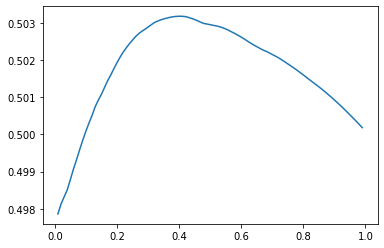

In [ ]:
param_results = pd.DataFrame({'params':gs.cv_results_['params'], 
              'params_numeric':np.arange(0.01,1,0.01), 
              'score':gs.cv_results_['mean_test_score']})
plt.plot(param_results['params_numeric'],param_results['score'])


We still haven't obtained an error measurement on the testing data, which will allow us to compare our best regularised model with the unregularised one. 

Let's generate predictions and calculate our performance metrics:

In [ ]:
eval_ols(gs, X_train, y_train, X_test, y_test)

Train RMSE = 78.72
Test RMSE = 83.09
Train R^2 = 0.52
Test R^2 = 0.42


Let's see how well we do if we use a higher alpha parameter, even though its slightly suboptimal.

In [ ]:
clf = Lasso(alpha=0.5)
clf.fit(X_train, y_train)
eval_ols(clf, X_train, y_train, X_test, y_test)
print("Number of zeros: %d" % sum(clf.coef_ == 0))

Train RMSE = 78.84
Test RMSE = 83.06
Train R^2 = 0.51
Test R^2 = 0.42
Number of zeros: 32


The previous best model had a test RMSE of 82.86 (and $R^2$ of 0.41), so we now have a slightly better model. Regularization has also given us a way of obtaining an accurate model with fewer nonzero coefficients. Even when taking the higher suboptimal alpha, we still do nearly as well with even higher interpretability (5 fewer nonzeros than the optimal Lasso model). 

## Exercise: Your turn!

Implement and cross-validate a model of your choice. Report your best score on the test set.

We suggest to try Ridge or ElasticNet for now.
Check their documentation!


- Ridge: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
- ElasticNet: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

The process is the same as before:

1. Import the relevant packages
  - ```from sklearn.linear_model import Ridge```
  - ```from sklearn.linear_model import ElasticNet```

2. Choose the model you want to cross-validate and prepare the hyperparameters values in a dictionary.

3. Build a grid search for your model.

4. Fit your grid search and extract the best model.

5. Evaluate on the test set.

For those of you who are already Python experts, try to beat my personal baseline on this train/test split!

*R2: 0.49*

*RMSE: 77.57* 

I haven't tried my best, so I have high hopes on you! But don't cheat by overfitting the testing set, do an honest validation or cross-validation :p



# Part 2: Classification
So far we've looked at models which predict a continuous response variable. There are many related models which predict categorical outcomes, such as whether an email is spam or not, or which digit a handwritten number is. We'll take a brief look at three of these: logistic regression and classification trees.

### Logistic Regression
Logistic regression is part of the class of generalized linear models (GLMs), which build directly on top of linear regression. These models take the linear fit and map it through a non-linear function. Linear regression has the form $$y_i=w_0+w_1 x_{i,1}+w_2 x_{i,2}=w^Tx_i,$$ whereas a GLM model has the form $$y_i=f(w^Tx_i).$$ 

For logistic regression, the function $f(\cdot)$ is given by $\displaystyle f(z) = \frac{1}{1+\exp(-z)}$ (the *logistic function*).

Let's apply a logistic regression model to the `listings` data. Let's try to predict which listings have elevators in the building by using `price` as a predictor. Remember that our `amenity_Elevator_in_Building` variable already stores our binary outcome of interest (1 = elevator, 0 = no elevator).

We need to re-split our data with y as the `amenity_Elevator_in_Building` variable. We will also *stratify* our split on this variable, meaning that the data is split to preserve the ratio of units with elevators in both the training and testing sets.

In [ ]:
features =  listings.columns.drop(['id', 'scrape_id', 'host_id', 'latitude', 'longitude', 
                                   'host_total_listings_count','calculated_host_listings_count',
                                   'availability_30','availability_60', 'availability_90', 'availability_365',
                                   'amenity_Elevator_in_Building', 'ols_pred', 'ols_resid'])
X_train, X_test, y_train, y_test = train_test_split(listings[features], listings['amenity_Elevator_in_Building'], 
                                                    train_size = 0.7, random_state = 2,
                                                   stratify = listings['amenity_Elevator_in_Building'])


Instead of linear regression, we'll now use `LogisticRegression()`, but the syntax is very similar. We'll skip ahead directly to using a grid search to tune regularization parameters. As you can see, the same steps apply even with a new model:
1. Define a parameter grid
2. Initialize a GridSearchCV object with the tuning grid and other fixed parameters
3. Fit the model!

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the grid that we want to search over
param_grid = {'C': np.arange(0.001, 1, 0.05), 
              'penalty': ['l2','l1'], 
              'solver': ['liblinear']}

# Define the parameters for the model 
gs = GridSearchCV(LogisticRegression(random_state=42, max_iter = 1000),
                  return_train_score=True, 
                  param_grid=param_grid, 
                  scoring='roc_auc',
                  cv=5, verbose = 0)
## Fit the model
random.seed(1)
gs.fit(X_train, y_train)
m_lr = gs.best_estimator_
print("Best parameters: ", gs.best_params_)

Best parameters:  {'C': 0.901, 'penalty': 'l1', 'solver': 'liblinear'}


In [ ]:
# Let's look at the coefficients
coef_output = pd.DataFrame({'feature':X_train.columns,
              'coefficient':m_lr.coef_[0]})

print("Number of zeros: %d" % (coef_output.query('coefficient == 0').shape[0]))
coef_output.sort_values('coefficient')

Number of zeros: 10


feature  coefficient
64            property_type_House    -3.246227
66        property_type_Townhouse    -0.910455
48       amenity_Indoor_Fireplace    -0.830133
45               amenity_other_50    -0.677589
29      amenity_Fire_Extinguisher    -0.439500
..                            ...          ...
20                amenity_Kitchen     0.957530
58                   amenity_Pool     1.336193
46                    amenity_Gym     1.965103
59                amenity_Doorman     2.237390
57  amenity_Wheelchair_Accessible     2.948121

[67 rows x 2 columns]

We can now explore out-of-sample performance. Ultimately, we want to predict whether or not a listing has an elevator. However, logistic regression gives us something a bit different: a probability that each listing has an elevator. This gives us flexibility in the way we predict. The most natural thing would be to predict that any listing with predicted probability above 0.5 *has* an elevator, and any listing with predicted probability below 0.5 *does not have* an elevator. But what if I use a wheelchair and I want to be really confident that there's going to be an elevator? I may want to use a cutoff value of 0.9 rather than 0.5. In fact, we could choose any cutoff value and have a corresponding prediction model.	

This is where AUC comes in. For every cutoff, we'll plot the *false positive rate* against the *true positive rate* and then take the area under this curve.	

**Question**: As a sanity check: What is the true positive rate and false positive rate of a random classifier that chooses "has an elevator" with probability of $\alpha$? (i.e. a classifier that randomly predicts *positive* $\alpha$% of the time.) What is the AUC for this classifier?

**Answer**: Both the true positive rate and false positive rate are $\alpha$. The AUC is 0.5.

scikit-learn allows us to easily plot ROC curves and calculate AUC. Here's an example. We'll write our evaluation in a function so that we can evaluate other models in the same way.

Train AUC: 0.916
Test AUC: 0.901


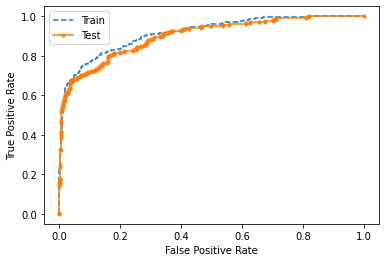

In [ ]:
train_pred = m_lr.predict_proba(X_train)[:,1]
test_pred = m_lr.predict_proba(X_test)[:,1]

print("Train AUC: %.3f" % metrics.roc_auc_score(y_train, train_pred))
print("Test AUC: %.3f" % metrics.roc_auc_score(y_test, test_pred))

train_fpr, train_tpr, _ = metrics.roc_curve(y_train, train_pred)
test_fpr, test_tpr, _ = metrics.roc_curve(y_test, test_pred)

# plot the roc curve for the model
plt.plot(train_fpr, train_tpr, linestyle='--', label='Train')
plt.plot(test_fpr, test_tpr, marker='.', label='Test')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

We can also look at threshold-based metrics. By selecting a decision threshold $t$, we predict all observations with a predicted probability $\hat{y} \geq t$ to have an elevator and all others to have no elevator. 

Let's calculate the training and testing accuracy for our model:

In [ ]:
t = 0.5
print("Train Accuracy: %.3f" %  metrics.accuracy_score(y_train, train_pred > t))
print("Test Accuracy: %.3f" %  metrics.accuracy_score(y_test, test_pred > t))

# If we wanted to get all of the elements of the confusion matrix, we could pull them like this:
tn, fp, fn, tp = metrics.confusion_matrix(y_train, train_pred > t).ravel()

Train Accuracy: 0.897
Test Accuracy: 0.886


**Question:** What is the baseline accuracy for this prediction task?

**Answer:** The training set has 591/2449 = 24.1% elevators. A naive baseline model would predict the most common class, "no elevators" for all observations. This would be correct 75.9\% of the time on the training set. The testing set also has elevators in 24.2\% of units, so it would have 75.8\% accuracy. (Remember that we stratified our sample, so it is not coincidental that the percentages are the same!).

Before we move on, we'll wrap all of our evaluation steps into a function that we can use to evaluate other models in a consistent way.

In [ ]:
def classification_evaluation(model, X_train, y_train, X_test, y_test, t = 0.5):
    train_pred = model.predict_proba(X_train)[:,1]
    test_pred = model.predict_proba(X_test)[:,1]

    print("Train AUC: %.3f" % metrics.roc_auc_score(y_train, train_pred))
    print("Test AUC: %.3f" % metrics.roc_auc_score(y_test, test_pred))
    
    print("\nTrain Accuracy: %.3f" %  metrics.accuracy_score(y_train, train_pred > t))
    print("Test Accuracy: %.3f" %  metrics.accuracy_score(y_test, test_pred > t))

    train_fpr, train_tpr, _ = metrics.roc_curve(y_train, train_pred)
    test_fpr, test_tpr, _ = metrics.roc_curve(y_test, test_pred)

    # plot the roc curve for the model
    plt.plot(train_fpr, train_tpr, linestyle='--', label='Train')
    plt.plot(test_fpr, test_tpr, marker='.', label='Test')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

Train AUC: 0.916
Test AUC: 0.901

Train Accuracy: 0.897
Test Accuracy: 0.886


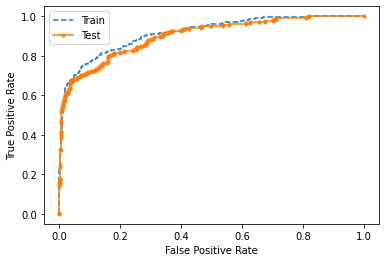

In [ ]:
classification_evaluation(m_lr, X_train, y_train, X_test, y_test)

As you can see, `sklearn.metrics` is versatile and allows you to calculate and plot a bunch of different performance metrics. In our case, this model gives a test AUC of 0.742. The worst possible is 0.5 - random guessing. We've built a pretty good model!


### Classification Trees 
We will briefly explore classification trees (often referred to as CART, for Classification And Regression Trees).

A (binary) classification tree makes predictions by grouping similar observations and then assigning a probability to each group using the proportion of observations within that group that belong to the positive class. Groups can be thought of as nodes on a tree, and tree branches correspond to logical criteria on the predictor variables. There's a lot of neat math that goes into building the trees, but we won't get into that today. For now let's get familiarized by looking at a simple example. We will use the `DecisionTreeClassifier` in scikit-learn.	

#### Tuning the CART model
If we want to construct high accuracy decision tree models, then we need to tune the parameters.  CART has many parameters that specify how the decision tree is constructed. Today we'll focus on `max_depth`. 
* If the tree is too big => too many splits => we have an over-fitting problem.
* If the tree is too small => too few splits => we have an under-fitting problem.

We want to find a tree in the middle, that is "just right". We'll use `GridSearchCV` package to tune the tree depth using cross-validation. We'll also try out a couple of different criteria.

The model construction step follows the same established pattern.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Define the grid that we want to search over
param_grid = {"max_depth": np.arange(3,10,1), "criterion": ['gini', 'entropy']}

# Define the parameters for the model 
gs = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  return_train_score=True, 
                  param_grid=param_grid, 
                  scoring='roc_auc',
                  cv=5, verbose = 0)

## Fit the model
random.seed(1)
gs.fit(X_train, y_train)
m_cart = gs.best_estimator_
print("Best parameters: ", gs.best_params_)

Best parameters:  {'criterion': 'entropy', 'max_depth': 8}


We can plot and save the resulting tree as follows:	

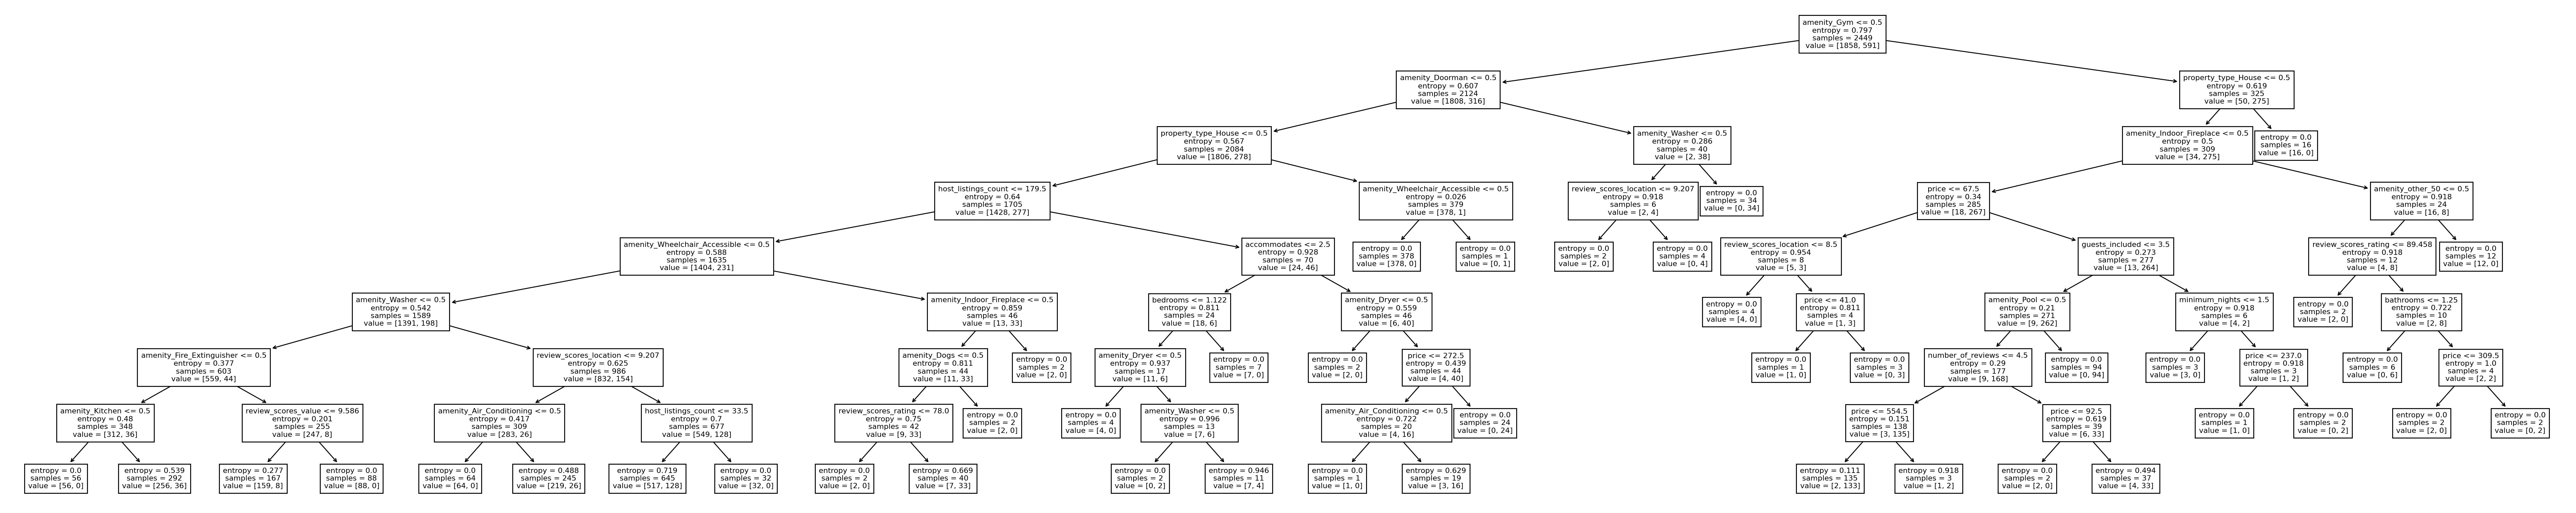

In [ ]:
from sklearn.tree import plot_tree

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (50,10), dpi=200)
plot_tree(m_cart, feature_names = X_train.columns, filled = False, fontsize = 8);
fig.savefig('cart_tree.png')

Let's use our evaluation function from before to see how well this model performs! 

Train AUC: 0.915
Test AUC: 0.870

Train Accuracy: 0.911
Test Accuracy: 0.898


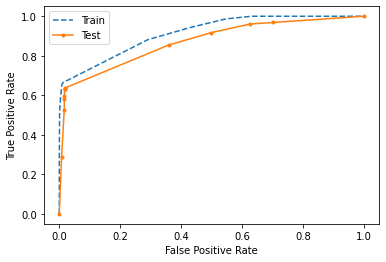

In [ ]:
classification_evaluation(m_cart, X_train, y_train, X_test, y_test)

The CART model does worse than the logistic regression model, with an AUC of 0.870 (vs. 0.9) on the test set.

### Random Forests
We will briefly take a look at random forests, using the [RandomForestClassifier()](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). A random forest is a collection of slightly randomized decision trees (hence the name "forest"), and can be used for classification or prediction. They often have excellent predictive performance, but can be expensive to train and lack interpretability. Random forests have many hyperparameters that can be tuned to achieve the best possible predictive performance. Perhaps the most important hyperparameter is the number of trees to include in the forest. More trees results in a longer training time but can improve prediction and decrease overfitting.
The goal of Random Forest is to train a pool of base tree learners with a high variance but a small bias. They are not necessarily weak learners!
With bagging, we explicitly train weaker (but not necessarily weak) learners.

Let's start by training a random forest model for a classification task. We will perform the same task of predicting whether or not a listing has an elevator, using price and neighborhood as predictors. We will compare the performance of random forest to what we got using our simple CART model. We'll use a grid search to tune the number of estimators.

*Note: This will take a few minutes!*

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [100,200,300],
     'max_depth': np.arange(3,8,1),
     'max_features': ['auto'],
     'min_samples_leaf': [0.01,0.02],
    'criterion' :['gini']
}
        
# Define the parameters for the model 
gs = GridSearchCV(RandomForestClassifier(random_state=42),
                  return_train_score=True, 
                  param_grid=param_grid, 
                  scoring='roc_auc',
                  cv=5, verbose = 0)

## Fit the model
random.seed(1)
gs.fit(X_train, y_train)
m_rf = gs.best_estimator_
print("Best parameters: ", gs.best_params_)

Best parameters:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 0.01, 'n_estimators': 300}


Train AUC: 0.932
Test AUC: 0.891

Train Accuracy: 0.878
Test Accuracy: 0.880


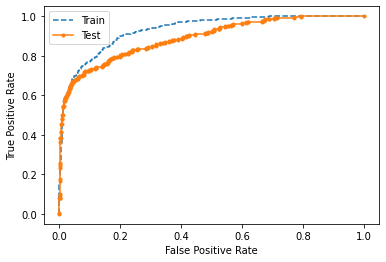

In [ ]:
# Let's evaluate the model performance
classification_evaluation(m_rf, X_train, y_train, X_test, y_test)

Compare this to what we got using CART, which had training AUC of 0.87. The tuned random forest model improves on the CART model. In general, random forests give stronger performance than single decision trees, but there is a sacrifice in interpretability. Interestingly, the logistic regression model is slightly better than the random forest model. The prediction accuracy is now much better, and it doesn't look we are overfitting *too* much. It would likely be even better if the other hyperparameters of the random forest model were properly tuned! 

### Boosted Trees

Boosting means combining a learning algorithm in series to achieve a strong learner from many sequentially connected weak learners. In case of gradient boosted decision trees algorithm, the weak learners are decision trees.

Each tree attempts to minimize the errors of the previous trees. Trees in boosting are weak learners but adding many trees in series and each focusing on the errors from previous one make boosting a highly efficient and accurate model.

A major difference between random forests and boosting algorithms is the overall size of the trees. In a random forest, we tend to choose trees as strong learners — they would do just fine as a decision tree on their own. In boosting algorithms, trees are artificially limited to very shallow depths (in practice rarely more than depth 5), to ensure that each model is only slightly better than random chance.

We'll start with the famous XGBoost, maybe the most widely used machine learning model!

In [ ]:
import xgboost as xgb
import time

# Define the parameter grid
param_grid = {
    'n_estimators': [100,200],
     'max_depth': np.arange(2,6,1),     
}
        
# Define the parameters for the model 
gs = GridSearchCV(xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
                  return_train_score=True, 
                  param_grid=param_grid, 
                  scoring='roc_auc',
                  cv=5, verbose = 0)

## Fit the model
random.seed(1)
start_time = time.time()
gs.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

m_xgb = gs.best_estimator_
print("Best parameters: ", gs.best_params_)

--- 22.657960653305054 seconds ---
Best parameters:  {'max_depth': 4, 'n_estimators': 200}


Train AUC: 0.991
Test AUC: 0.916

Train Accuracy: 0.941
Test Accuracy: 0.891


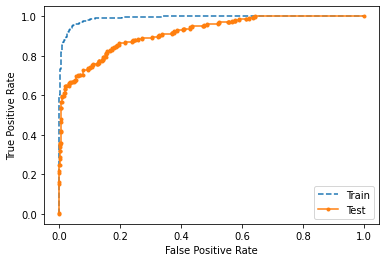

In [ ]:
classification_evaluation(m_xgb, X_train, y_train, X_test, y_test)

LightGBM, short for Light Gradient Boosting Machine, is another distributed gradient boosting framework originally developed by Microsoft. Light GBM uses leaf-wise splitting over depth-wise splitting which enables it to converge much faster but also leads to a higher tendency to overfit.

In [ ]:
import lightgbm as lgb

# Define the parameter grid
param_grid = {
    'n_estimators': [100,150],
     'max_depth': np.arange(2,6,1),
}
        
# Define the parameters for the model 
gs = GridSearchCV(lgb.LGBMClassifier(random_state=42),
                  return_train_score=True, 
                  param_grid=param_grid, 
                  scoring='roc_auc',
                  cv=5, verbose = 0)

## Fit the model
random.seed(1)

start_time = time.time()
gs.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

m_lgb = gs.best_estimator_
print("Best parameters: ", gs.best_params_)

--- 5.367004632949829 seconds ---
Best parameters:  {'max_depth': 3, 'n_estimators': 150}


Train AUC: 0.969
Test AUC: 0.910

Train Accuracy: 0.916
Test Accuracy: 0.896


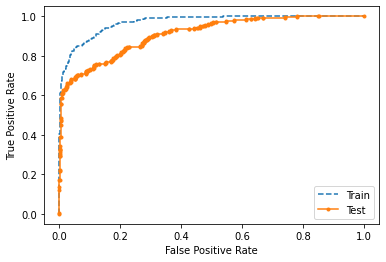

In [ ]:
classification_evaluation(m_lgb, X_train, y_train, X_test, y_test)

### Exercise: Get a better boosted-tree model!

In practice, we can use a more thorough gridsearch on other hyperparameters such as learning rate, min_sample_by_leaf, etc. 

Check the documentation of LightGBM and try to see if you can find a better combination of hyperparameters by exploring the different possibilities!
- Documentation: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
- Advice on parameter tuning for LightGBM: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html#for-better-accuracy



In [ ]:
# Your code


### Neural Networks

We won't cover neural networks during SIP, it would be too much! You will have to wait for IAP!
However, if you are interested by the topic before hand, I am glad to discuss more with you!

I suggest the following resources:
- MIT 6.S191, Introduction to Deep Learning | http://introtodeeplearning.com/ (Very famous one-week IAP class taught by students. Many MBAn students take it every year.)
- For something faster, but also pretty complete for a 2h timeframe, I taught Deep Learning last IAP to ORC students: https://github.com/adelarue/cos_2021/tree/main/5_deep_learning
- The Deep Learning Book, Ian Goodfellow and Yoshua Bengio and Aaron Courville | https://www.deeplearningbook.org/
- The Deep Learning Cheetsheets, by Afshine Amidi and Shervine Amidi | https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-deep-learning#

In general, we use TensorFlow or Pytorch to implement neural-networks but scikit-learn includes a rudimentary version to code feedforward neural networks.

In [ ]:
from sklearn.neural_network import MLPClassifier

# Define the parameter grid
param_grid = {
     'hidden_layer_sizes': [(128), (128,64)],
     'alpha': [1e-3, 1e-4]
}

#It is very important to scale the data for neural networks.
std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train_standardized2 = std_scaler.transform(X_train)
X_test_standardized2 = std_scaler.transform(X_test)
        
# Define the parameters for the model 
gs = GridSearchCV(MLPClassifier(random_state=42),
                  return_train_score=True, 
                  param_grid=param_grid, 
                  scoring='roc_auc',
                  cv=5, verbose = 0)

## Fit the model
random.seed(1)
gs.fit(X_train_standardized2, y_train)
m_mlp = gs.best_estimator_
print("Best parameters: ", gs.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Best parameters:  {'alpha': 0.0001, 'hidden_layer_sizes': 128}


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Train AUC: 1.000
Test AUC: 0.893

Train Accuracy: 1.000
Test Accuracy: 0.875


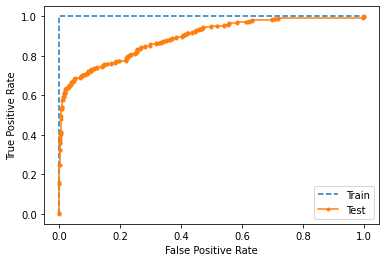

In [ ]:
classification_evaluation(m_mlp, X_train_standardized2, y_train, X_test_standardized2, y_test)

### Advanced Exercise: Understanding and Tuning TabNet

If everything we have done so far is too easy for you, try TabNet, a popular deep learning model for tabular data. Otherwise, just skip :p

I let you in the wild, please tune the model using Google to find the documentation and maybe some advice!

In [ ]:
!pip install pytorch-tabnet

Device used : cpu
epoch 0  | loss: 0.86249 | val_0_auc: 0.58449 |  0:00:00s
epoch 1  | loss: 0.64514 | val_0_auc: 0.55128 |  0:00:00s
epoch 2  | loss: 0.57609 | val_0_auc: 0.59908 |  0:00:00s
epoch 3  | loss: 0.51971 | val_0_auc: 0.6543  |  0:00:01s
epoch 4  | loss: 0.50895 | val_0_auc: 0.66878 |  0:00:01s
epoch 5  | loss: 0.4852  | val_0_auc: 0.66806 |  0:00:01s
epoch 6  | loss: 0.46336 | val_0_auc: 0.67198 |  0:00:01s
epoch 7  | loss: 0.44881 | val_0_auc: 0.6767  |  0:00:01s
epoch 8  | loss: 0.44996 | val_0_auc: 0.6873  |  0:00:02s
epoch 9  | loss: 0.44546 | val_0_auc: 0.70493 |  0:00:02s
epoch 10 | loss: 0.43838 | val_0_auc: 0.71642 |  0:00:02s
epoch 11 | loss: 0.42992 | val_0_auc: 0.72217 |  0:00:02s
epoch 12 | loss: 0.42401 | val_0_auc: 0.72431 |  0:00:03s
epoch 13 | loss: 0.40786 | val_0_auc: 0.73688 |  0:00:03s
epoch 14 | loss: 0.41071 | val_0_auc: 0.74103 |  0:00:03s
epoch 15 | loss: 0.40469 | val_0_auc: 0.7515  |  0:00:03s
epoch 16 | loss: 0.40145 | val_0_auc: 0.74929 |  0:00:

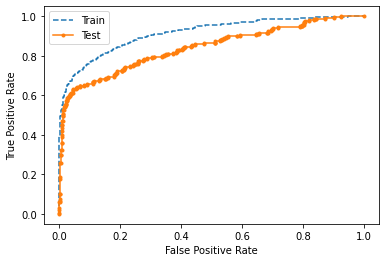

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor

clf = TabNetClassifier() 
X_train_tabnet, X_valid_tabnet, y_train_tabnet, y_valid_tabnet = train_test_split(X_train_standardized2, y_train,
                                                    train_size = 0.75, random_state = 1)
clf.fit(
  X_train_tabnet, y_train_tabnet,
  eval_set=[(X_valid_tabnet, y_valid_tabnet)]
)
classification_evaluation(clf, X_train_standardized2, y_train, X_test_standardized2, y_test)

# Part 3: Advanced Topics 




## A. Interpretability / Explainability


#### Interpreting Random Forest and Boosted-Tree Models
Although random forest and boosted-tree models are not very interpretable and hard to visualize, there is a popular method called *variable importance* that is commonly used. We will use the built-in `feature_importances_` from these models. This tells us which variables the random forest or boosted-tree model has determined as the most important for predicting whether or not a listing contains an elevator. It uses Gini importance, which is the mean decrease in node impurity (you can read more about this metric online), to rank the importance of all of the predictors used in the model. There are other metrics besides the Gini Importance that can also be used as a metric.

<BarContainer object of 10 artists>

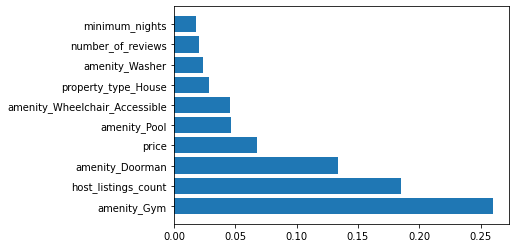

In [ ]:
#Random Forest
importance_output = pd.DataFrame({'feature':X_train.columns,
                                 'importance':m_rf.feature_importances_}).sort_values('importance', ascending = False)

plt.barh(importance_output['feature'][0:10], importance_output['importance'][0:10])

<BarContainer object of 10 artists>

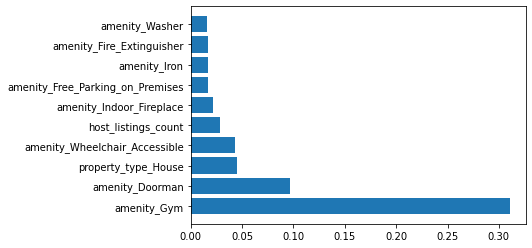

In [ ]:
#XGBoost
importance_output = pd.DataFrame({'feature':X_train.columns,
                                 'importance':m_xgb.feature_importances_}).sort_values('importance', ascending = False)

plt.barh(importance_output['feature'][0:10], importance_output['importance'][0:10])

<BarContainer object of 10 artists>

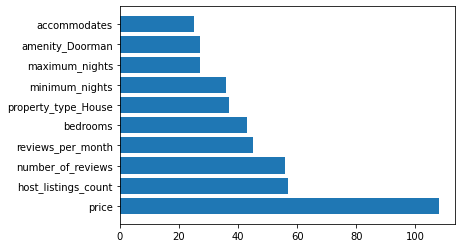

In [ ]:
#LightGBM
importance_output = pd.DataFrame({'feature':X_train.columns,
                                 'importance':m_lgb.feature_importances_}).sort_values('importance', ascending = False)

plt.barh(importance_output['feature'][0:10], importance_output['importance'][0:10])

For XGBoost, the variable importance plot shows us that whether or not the unit has a gym, how many listings the host has, whether there is a doorman, and the unit price are the most important features. 

This not only gives us intuition about our models, but can also be used to select variables to train other models. However, there are some shortcomings. For example, price is important in the LightGBM model, but what is the direction of this relationship? Are high or low prices associated with elevator likelihood?

#### Interpretation with SHapley Additive exPlanations (SHAP)
There has been a lot of research devoted to better methods of interpreting "black box" machine learning models, like random forests. The [SHAP](https://shap.readthedocs.io/en/latest/) package offers an easy-to-use interface that estimates the contribution of each variable to each observation's prediction. This gives insight into both the *magnitude* and *directionality* of a feature's importance. The package also allows for plots of interactions between variables to understand important nonlinearities. We'll do this for the XGBoost model, but we could use the same package for many other models (including neural networks).

In [ ]:
!pip install shap

     |████████████████████████████████| 371 kB 4.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509256 sha256=3b6417dedb14efa27efc2234477b315bc6828c097f43e8a194fb3a8b1402967e
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [ ]:
import shap  ## you can install this in terminal: 'conda install -c conda-forge shap'

explainer = shap.TreeExplainer(m_xgb); # data=test_x, model_output="probability");
shap_values = explainer.shap_values(X_train)#[1]; # index 1 pulls the P(y=1) SHAP values for RandomForest.

##### Summary Plot
We'll start with the summary plot, which ranks the features by importance (mean absolute SHAP value) and also shows the direction of the relationship. 

Features are ordered by decreasing significance, with the most important feature listed at the top of the plot. For a given feature, the corresponnding row shows a plot of the feature's impact on the prediction as the value ranges from its lowest (blue) to highest (red) value. Higher SHAP values correspond to increased likelihood of having a positive outcome (i.e. having an elevator). Thus, features with the color scale oriented blue to red (moving left to right) have increasing risk as the feature increases, such as hotel count. Note: the categorical variables are encoded as a binary value (e.g. 0=no gym, 1=gym), so "higher" values correspond to having the indicated feature.

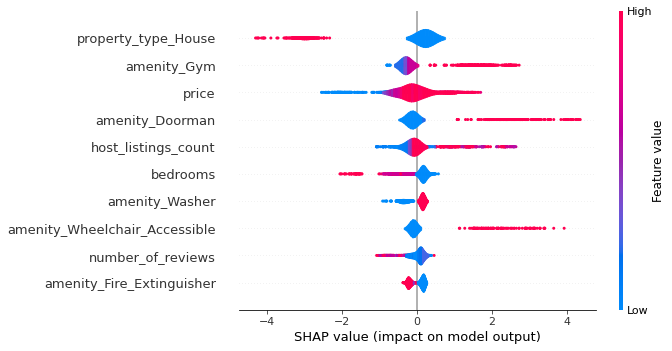

In [ ]:
plt.close()
shap.summary_plot(shap_values, X_train, show=True,
                  max_display=10,
                  plot_type="violin")

The summary plot gives us insight into the key driving features; this is similar to Gini feature importance but gives us more granular insight.
- Gym, Doorman, Washer, Wheelchair Accessible,... all increase the probability of an elevator.
- As price increases, the probability of an elevator increases.
- Listings from hosts with more listings have higher probability of an elevator.
- The property type being a house decreases the probability.

##### Dependence Plots

Let's dive into the relationship between price and whether the unit is predicted to have an elevator. We can create a dependence plot or price to see how varied prices affect the output probability.

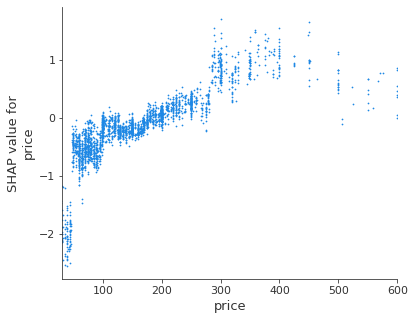

In [ ]:
plt.close()
shap.dependence_plot('price', shap_values, X_train,
                       interaction_index = None,
                       xmin="percentile(1)", xmax="percentile(99)",
                       dot_size=3,show=False)

It looks like for the listings below \$180/night, the price lowers the probability that the unit will have an elevator (SHAP value < 0). Above \$180night, there is a positive impact on probability of having an elevator. Above \$300/night or so, however, the impact on the probability stabilizes; the probability does not continue to increase with prices above \$300. 

###### Force Plots
Finally, force plots let us see how each feature contributes to the final probability for a given observation. The red features contribute to increases in the elevator probability, and the blue features decrease. The width of the bar (decreasing from the center) indicates the magnitude. 

In [ ]:
id=1 # Try id=1 and id=5 to see a high and low probability example
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values[id],
               feature_names = X_train.columns)

## B. Ensemble Modeling


Our goal is to obtain additional improvement from the top previous models. A very successful technique, widely used in data science competitions, is to build an ensemble model, i.e., using a combination (consensus) of different "base learners" to make a final decision. 

The general principle is to:
- create train/val/test sets. Note: It is important to create a validation set.
- fit a few different models on the TRAINING set, that we evaluate on the VALIDATION set
- train a consensus model using the predictions of these models on the VALIDATION set (which is unseen data) 
- evaluate the performance on the TEST set

QUESTION: Why is it important to maintain a validation data to build an ensemble model?

In [ ]:
#We keep our train/test set from previously but we separate our train set into train and val.
X_train_ensemble, X_val_ensemble, y_train_ensemble, y_val_ensemble = train_test_split(X_train, y_train, 
                                                    train_size = 0.75, random_state = 6,
                                                   stratify = y_train)

In [ ]:
#We previously trained several models. For prototyping sake, we don't do our validation or cross-validation again, but you always should in practice!

#Get predictions on unseen data
def create_prediction_data(model_list, X_train, y_train, X_val, y_val, X_test, y_test, verbose=False):
    df_val = pd.DataFrame()
    df_test = pd.DataFrame()
    for key in model_list:
        model_list[key].fit(X_train, y_train)
        df_val[key] = model_list[key].predict_proba(X_val)[:,1]
        df_test[key] = model_list[key].predict_proba(X_test)[:,1]
        if verbose:
            print("\n#### " + key +  " ####")
            print("Test AUC: ", metrics.roc_auc_score(y_test, model_list[key].predict_proba(X_test)[:,1]))
            print("Test Acc: ", metrics.accuracy_score(y_test, model_list[key].predict(X_test)))
        #classification_evaluation(model_list[key], X_train, y_train, X_test, y_test)
    return df_val, df_test

In [ ]:
#We get our ensemble data
d_1 = {'logreg': m_lr, 'cart': m_cart, 'rf': m_rf, 'xgb': m_xgb, 'lgb': m_lgb}
d_2 = {'logreg': m_lr, 'rf': m_rf, 'xgb': m_xgb, 'lgb': m_lgb}
d_3 = {'logreg': m_lr, 'rf': m_rf, 'xgb': m_xgb, 'cart': m_cart}

df_val_1, df_test_1 = create_prediction_data(d_1, X_train_ensemble, y_train_ensemble, X_val_ensemble, y_val_ensemble, X_test, y_test, verbose = True)
df_val_2, df_test_2 = create_prediction_data(d_2, X_train_ensemble, y_train_ensemble, X_val_ensemble, y_val_ensemble, X_test, y_test)
df_val_3, df_test_3 = create_prediction_data(d_3, X_train_ensemble, y_train_ensemble, X_val_ensemble, y_val_ensemble, X_test, y_test)


#### logreg ####
Test AUC:  0.9020496181695882
Test Acc:  0.8895238095238095

#### cart ####
Test AUC:  0.847863827009061
Test Acc:  0.8933333333333333

#### rf ####
Test AUC:  0.89087168124085
Test Acc:  0.8790476190476191

#### xgb ####
Test AUC:  0.9126587662723064
Test Acc:  0.8942857142857142

#### lgb ####
Test AUC:  0.9060163019823527
Test Acc:  0.8971428571428571


### Average Ensemble

The simplest version of an ensemble model is the average of the base models' probability outputs. Another possibility is to make a "vote" among the base models and use the majority vote as our prediction.

In [ ]:
print("\n#### Probability average with CART included ####")
print("Test AUC: ", metrics.roc_auc_score(y_test, df_test_1.mean(axis = 1)))
print("Test Acc: ", metrics.accuracy_score(y_test, df_test_1.mean(axis = 1) > 0.5))

print("\n#### Probability average without CART ####")
print("Test AUC: ", metrics.roc_auc_score(y_test, df_test_2.mean(axis = 1)))
print("Test Acc: ", metrics.accuracy_score(y_test, df_test_2.mean(axis = 1) > 0.5))

print("\n#### Probability average without LightGBM ####")
print("Test AUC: ", metrics.roc_auc_score(y_test, df_test_3.mean(axis = 1)))
print("Test Acc: ", metrics.accuracy_score(y_test, df_test_3.mean(axis = 1) > 0.5))


#### Probability average with CART included ####
Test AUC:  0.9108831559371662
Test Acc:  0.8952380952380953

#### Probability average without CART ####
Test AUC:  0.9118426779567127
Test Acc:  0.8990476190476191

#### Probability average without LightGBM ####
Test AUC:  0.9101313654888618
Test Acc:  0.8961904761904762


### Weighted Average Ensemble

A slightly more sophisticated version of an ensemble model is the weighted average of the base models' probability outputs. We can train a Lasso Logistic Regression to obtain the different weights.

In [ ]:
# Weighted average
# Define the grid that we want to search over
param_grid = {'C': np.arange(0.001, 1, 0.05), 
              'penalty': ['l2','l1'], 
              'solver': ['liblinear']}

# Define the parameters for the model 
gs_ensemble = GridSearchCV(LogisticRegression(random_state=42, max_iter = 1000),
                  return_train_score=True, 
                  param_grid=param_grid, 
                  scoring='roc_auc',
                  cv=5, verbose = 0)
## Fit the model
random.seed(1)
gs_ensemble.fit(df_val_1, y_val_ensemble)
m_lr_ensemble = gs_ensemble.best_estimator_
print("Best parameters: ", gs_ensemble.best_params_)

Best parameters:  {'C': 0.201, 'penalty': 'l1', 'solver': 'liblinear'}


In [ ]:
print("Test AUC: ", metrics.roc_auc_score(y_test, m_lr_ensemble.predict_proba(df_test_1)[:,1]))
print("Test Acc: ", metrics.accuracy_score(y_test, m_lr_ensemble.predict(df_test_1)))


Test AUC:  0.9135688283939383
Test Acc:  0.8980952380952381


In [ ]:
# Let's look at the coefficients
coef_output = pd.DataFrame({'feature':df_test_1.columns,
              'coefficient':m_lr_ensemble.coef_[0]})

print("Number of zeros: %d" % (coef_output.query('coefficient == 0').shape[0]))
coef_output.sort_values('coefficient')

Number of zeros: 3


feature  coefficient
1    cart     0.000000
2      rf     0.000000
4     lgb     0.000000
0  logreg     1.922150
3     xgb     3.028796

The "optimal" weighted average ensemble leads to roughly the same top performance using only 3 out of the 5 models. This is extremely desired for deployment purposes as it means fewer models will need to be implemented which results in a faster and more reliable pipeline.

## C. AutoML



### TPOT

Tree-based Pipeline Optimization Tool, or TPOT for short, is a Python library for automated machine learning.

TPOT uses a tree-based structure to represent a model pipeline for a predictive modeling problem, including data preparation and modeling algorithms, and model hyperparameters.

The repository is here: https://github.com/EpistasisLab/tpot

Don't hesitate to search more about this on Google.

In [ ]:
#First install tpot
!pip install tpot

     |████████████████████████████████| 87 kB 2.9 MB/s 
     |████████████████████████████████| 173.5 MB 61 kB/s 
     |████████████████████████████████| 160 kB 47.2 MB/s 
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11952 sha256=296f3b4ef1c52433aad5500df94ee7e4c2914bca934c7de46ea794215b52fbba
  Stored in directory: /root/.cache/pip/wheels/e2/d2/79/eaf81edb391e27c87f51b8ef901ecc85a5363dc96b8b8d71e3
Successfully built stopit
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [ ]:
#The rest of the pipeline is the same as usual
from tpot import TPOTClassifier
from tpot import TPOTRegressor

tpot = TPOTClassifier(generations=3, population_size=50, verbosity=2, random_state=42)

#Note: the training can be very long (>15min), ideal to take a well-deserved break while waiting for the results!
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.


Optimization Progress:   0%|          | 0/200 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8971078001752849

Generation 2 - Current best internal CV score: 0.8995584491465298

Generation 3 - Current best internal CV score: 0.8995584491465298

Best pipeline: ExtraTreesClassifier(Normalizer(SGDClassifier(input_matrix, alpha=0.001, eta0=1.0, fit_intercept=False, l1_ratio=1.0, learning_rate=invscaling, loss=squared_hinge, penalty=elasticnet, power_t=10.0), norm=l1), bootstrap=False, criterion=entropy, max_features=0.8500000000000001, min_samples_leaf=5, min_samples_split=15, n_estimators=100)
0.8971428571428571


In [ ]:
tpot.export('tpot_elevator.py')
!cat tpot_elevator.py

import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import Normalizer
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=42)

# Average CV score on the training set was: 0.8995584491465298
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=SGDClassifier(alpha=0.001, eta0=1.0, fit_intercept=False, l1_ratio=1.0, learning_rate="invscaling", loss="squared_hinge", pen

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

exported_pipeline = make_pipeline(
    StackingEstimator(estimator=MultinomialNB(alpha=0.001, fit_prior=True)),
    ExtraTreesClassifier(bootstrap=False, criterion="gini", max_features=0.25, min_samples_leaf=3, min_samples_split=12, n_estimators=100)
)

# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

exported_pipeline.fit(X_train, y_train)
print("Test AUC: ", metrics.roc_auc_score(y_test, exported_pipeline.predict_proba(X_test)[:,1]))
print("Test Acc: ", tpot.score(X_test, y_test)) #metrics.accuracy_score(y_test, exported_pipeline.predict(X_test)))

Test AUC:  0.9092114113876468
Test Acc:  0.8971428571428571


Pretty neat eh? 
Our best standalone model was LightGBM with:
- Test AUC:  0.906
- Test Acc:  0.897

Our best ensemble had:
- Test AUC:  0.909
- Test Acc:  0.899

Now, with no effort, we got:
- Test AUC:  0.909
- Test Acc:  0.901

Could a machine could do our job then?
Do Androids Dream of Electric Sheep?

### Lazypredict

Lazypredict is a package that trains the most popular machine learning models on your data, with their default hyperparameters values. It can be very useful to find out what are the top performing models before you start yourself the hyperparameter tuning.

I also like to use it to obtain a set of base learners for an ensemble model. I generally keep the 10-15 out-of-the-box top models given by ```lazypredict``` and use a Lasso ensemble afterwards.

In [ ]:
!pip install lazypredict
import lazypredict
#Important note: 
#Some of the package requirements from lazypredict are not exactly the same as the default in Google Colab.
#Therefore, you will need to install lazypredict and then RESTART a runtime (Runtime -> Restart a runtime)

     |████████████████████████████████| 25.9 MB 968 bytes/s 
     |████████████████████████████████| 1.2 MB 22.2 MB/s 
     |████████████████████████████████| 6.8 MB 31.0 MB/s 
     |████████████████████████████████| 269 kB 48.1 MB/s 
     |████████████████████████████████| 72 kB 707 kB/s 
     |████████████████████████████████| 127.6 MB 6.9 kB/s 
     |████████████████████████████████| 302 kB 56.6 MB/s 
     |████████████████████████████████| 14.5 MB 8.5 kB/s 
     |████████████████████████████████| 248 kB 44.0 MB/s 
     |████████████████████████████████| 10.1 MB 34.0 MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44635 sha256=96e5df5397cb9690bf5404cb8b2f826459b7d5b44cf91c0a3c44bef24c7c6aa5
  Stored in directory: /root/.cache/pip/wheels/5e/03/1e/e1e954795d6f35dfc7b637fe2277bff021303bd9570ecea653
Successfully built PyYAML
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successful

In [ ]:
#As usual, you can use the Regressor or Classifier version
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


AttributeError: ignored

In [ ]:
reg = LazyClassifier(predictions = True, verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train_ensemble, X_val_ensemble, y_train_ensemble, y_val_ensemble)

#Performance is reported on the validation set
models

### Ensemble Modeling using LazyPredict (Very Advanced)

We can use LazyPredict to quickly obtain a pool of base learners. They won't be amazing but for a quick ensemble prototype that's good enough!

In [ ]:
#choose the list of base learners you want to be trained by lazypredict
#I commented some that were poorly performing or bugging for my specific code

base_learners = [('AdaBoostClassifier', sklearn.ensemble._weight_boosting.AdaBoostClassifier),
 ('BaggingClassifier', sklearn.ensemble._bagging.BaggingClassifier),
 ('BernoulliNB', sklearn.naive_bayes.BernoulliNB),
 ('CalibratedClassifierCV', sklearn.calibration.CalibratedClassifierCV),
 ('CategoricalNB', sklearn.naive_bayes.CategoricalNB),
 ('DecisionTreeClassifier', sklearn.tree._classes.DecisionTreeClassifier),
 #('DummyClassifier', sklearn.dummy.DummyClassifier),
 ('ExtraTreeClassifier', sklearn.tree._classes.ExtraTreeClassifier),
 ('ExtraTreesClassifier', sklearn.ensemble._forest.ExtraTreesClassifier),
 #('GaussianNB', sklearn.naive_bayes.GaussianNB),
 ('KNeighborsClassifier',
  sklearn.neighbors._classification.KNeighborsClassifier),
 #('LabelPropagation',
  #sklearn.semi_supervised._label_propagation.LabelPropagation),
 #('LabelSpreading', sklearn.semi_supervised._label_propagation.LabelSpreading),
 #('LinearDiscriminantAnalysis',
  #sklearn.discriminant_analysis.LinearDiscriminantAnalysis),
 #('LinearSVC', sklearn.svm._classes.LinearSVC),
 ('LogisticRegression', sklearn.linear_model._logistic.LogisticRegression),
 #('NearestCentroid', sklearn.neighbors._nearest_centroid.NearestCentroid),
 ('NuSVC', sklearn.svm._classes.NuSVC),
 #('PassiveAggressiveClassifier',
  #sklearn.linear_model._passive_aggressive.PassiveAggressiveClassifier),
 #('Perceptron', sklearn.linear_model._perceptron.Perceptron),
 #('QuadraticDiscriminantAnalysis',
  #sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis),
 ('RandomForestClassifier', sklearn.ensemble._forest.RandomForestClassifier),
 #('RidgeClassifier', sklearn.linear_model._ridge.RidgeClassifier),
 #('RidgeClassifierCV', sklearn.linear_model._ridge.RidgeClassifierCV),
 #('SGDClassifier', sklearn.linear_model._stochastic_gradient.SGDClassifier),
 #('SVC', sklearn.svm._classes.SVC),
 ('StackingClassifier', sklearn.ensemble._stacking.StackingClassifier),
 ('XGBClassifier', xgboost.sklearn.XGBClassifier),
 ('LGBMClassifier', lightgbm.sklearn.LGBMClassifier)]

#specify what are your base learners
lazypredict.Supervised.CLASSIFIERS = base_learners

In [ ]:
lazy = LazyClassifier(predictions = True, verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = lazy.fit(X_train_ensemble, X_val_ensemble, y_train_ensemble, y_val_ensemble)

#Get the dictionary of the trained models
d_base = lazy.provide_models(X_train_ensemble, X_val_ensemble, y_train_ensemble, y_val_ensemble)

In [ ]:
#Get the training and testing data for the ensemble model
df_val_lazy, df_test_lazy = create_prediction_data(d_base, X_train_ensemble, y_train_ensemble, X_val_ensemble, y_val_ensemble, X_test, y_test, verbose = True)

In [ ]:
# Weighted average of the base learners
# Define the grid that we want to search over

param_grid = {'C': np.arange(0.001, 1, 0.05), 
              'penalty': ['l2','l1'], 
              'solver': ['liblinear']}

# Define the parameters for the model 
gs_ensemble_lazy = GridSearchCV(LogisticRegression(random_state=42, max_iter = 1000),
                  return_train_score=True, 
                  param_grid=param_grid, 
                  scoring='roc_auc',
                  cv=5, verbose = 0)
## Fit the model
random.seed(1)
gs_ensemble_lazy.fit(df_val_lazy, y_val_ensemble)
m_lr_ensemble_lazy = gs_ensemble_lazy.best_estimator_
print("Best parameters: ", gs_ensemble_lazy.best_params_)

print("Test AUC: ", metrics.roc_auc_score(y_test, m_lr_ensemble_lazy.predict_proba(df_test_lazy)[:,1]))
print("Test Acc: ", metrics.accuracy_score(y_test, m_lr_ensemble_lazy.predict(df_test_lazy)))

#Notice we obtained the best AUC we had so far but the accuracy is slightly worse.

# Conclusion

### Model Selection
**Question:** Now that we have trained and evaluated so many different models, which one would you select?

**Answer:** It depends on the application, the stakeholders, and the costs of missed positives and negatives (or in continuous prediction, under- and over-predictions). 

In a problem like this, the prediction of whether an Airbnb listing will have an elevator is not highly consequential. However, consider a clinical decision support tool that predicts hospital re-admission or a model that predicts loan defaults. In such cases, there may be a higher premium on interpretability to ensure transparency for patients (or bank clients). 

On the other hand, a tool that is used to triage customer service calls within a company may not need to be as interpretable because it is used purely internally. 

## Take-aways
In this module, we have covered examples of machine learning methods for linear regression (ordinary and penalized) and classification.  This is just the tip of the iceberg.  There are tons more machine learning methods which can be easily implemented in Python.  

We haven't focused that much on the feature preprocessing and data cleaning (because it is boring?), but this is often one of the most important aspects. 

Remember to always scrutinize your data before doing serious modeling.

In particular: 
- look for outliers, 
- handle missing data (e.g., delete, impute, interpolate),
- observe the feature distributions,
- observe the feature correlations,
- consider engineering a few additional features 
- remember real-world data is always messy...

During modeling:
- always cross-validate or at least validate your hyperparameters,
- do not try to overfit your test set!
- think about deployment: will you have data drifts? Is your model easy to deploy? Does your model run fast?
- choose your evaluation metrics carefully.

To get some extra juice:
- consider using ensemble modeling, but if possible keep it simple
- autoML can save you a lot of time, I wish I knew it before!!

### Notes on sklearn modeling
- While the examples above used CART and Random Forests for classification tasks, there is almost identical syntax to run them for regression tasks. We won't go through these in details, but check out [DecisionTreeRegressor()](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) and [RandomForestRegressor()](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) for more information. 
- There are many, many classification algorithms implemented in `scikit-learn`. [Here's](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) an example that compares a broad set of methods, including SVM, k-Nearest Neighbors, and others.
- XGBoost and LightGBM follow nearly identical syntax to the examples above (using GridSearchCV). However, it is not implemented in scikit-learn. You can install the [xgboost](https://xgboost.readthedocs.io/en/latest/) library and then adapt the code above to this model.

### My top regression model

In [ ]:
#My top model for the Regression! Haven't tried any ensemble, but that would be my next step!
from sklearn.ensemble import GradientBoostingRegressor

grid = {'learning_rate':[0.05, 0.07, 0.1, 0.15],
        'max_depth': [3,4,5,6],
        'n_estimators':[100,150,200]}

# Define the parameters for the model 
gs = GridSearchCV(
    estimator = GradientBoostingRegressor(), 
    param_grid = grid, 
    cv=5)

## Fit the model
random.seed(1)
gs.fit(X_train, y_train)
m = gs.best_estimator_

## Print the best parameters determined by the cross-validation
print("Alpha: %.3f" % gs.best_params_['alpha'])
eval_ols(m, X_train, y_train, X_test, y_test)

rf = GradientBoostingRegressor()
rf.fit(X_train, y_train)
eval_ols(rf, X_train, y_train, X_test, y_test)